# **Final Project**
### Machine Learning Applications

---

**Marta Balairón García 100451724**

**Gracia Estrán Buyo 100452014**

**Marta Almagro Fuello 100451979**


---

## **1. Task 1: Text Preprocessing and vectorization**

---

Upload the dataset from Google Drive created before and import the necessary libraries:

In [1]:
import pandas as pd
import numpy as np
import pickle
import re
import os
import seaborn as sns
import matplotlib.pyplot as plt
import gensim

from gensim.models.phrases import Phrases
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.matutils import corpus2dense, corpus2csc
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.models import FastText
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import r2_score, accuracy_score
from sklearn.manifold import TSNE
from sklearn.naive_bayes import MultinomialNB 
from sklearn.linear_model import LogisticRegression

from google.colab import drive

drive.mount('/content/drive')

# MARTA ALMG
# Change to assignment directory 
# os.chdir('/content/drive/My Drive/AML') 

# with open('/content/drive/My Drive/AML/Biblia/Dataset.pkl', 'rb') as f:
#     dataset = pickle.load(f)

# MARTA BALAIRON
#drive.mount('/content/drive')
#path = '/content/drive/My Drive/Colab Notebooks/machine learning final project/Dataset.pkl'
#with open(path, 'rb') as f:
   #dataset = pickle.load(f)

# GRACIA
path = '/content/drive/My Drive/ColabNotebooks/MLapps/project/Dataset.pkl'
with open(path, 'rb') as f:
    dataset = pickle.load(f)


Mounted at /content/drive


In [2]:
dataset.head()

,Chapter,Book,Testament,Text
0,Capítulo 1,exodo,Old,Aflicción de los israelitas en Egipto 1:1 Est...
1,Capítulo 2,exodo,Old,Nacimiento de Moisés é2:1 Un varón de la fami...
2,Capítulo 3,exodo,Old,Llamamiento de Moisésé3:1 Apacentando Moisés ...
3,Capítulo 4,exodo,Old,é4:1 Entonces Moisés respondió diciendo: He ...
4,Capítulo 5,exodo,Old,Moisés y Aarón ante Faraón é5:1 Después Moisé...


###**• Step 1: Implementation of a pipeline for the preprocessing of the texts. For this task you can use the usual libraries (NLTK, Spacy), or any other library that you consider appropriate.**


In [3]:
#!pip install --upgrade spacy
import spacy
!python -m spacy download es_core_news_md # Spanish pipeline optimized for CPU

2023-05-07 19:41:51.051801: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 12.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')


In [4]:
# Install of a visualizer for LDA
!pip install pyLDAvis==2.1.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97736 sha256=535edfbd59cfda66988e2e9cf21356c69cb5eb2eac303b849085d41e689fe8fe
  Stored in directory: /root/.cache/pip/wheels/d9/93/d6/16c95da19c32f037fd75135ea152d0df37254c25cd1a8b4b6c
Successfully built pyLDAvis


In [5]:
nlp = spacy.load('es_core_news_md')
nlp.disable_pipe("parser")

# Tokenization, Homogeneization and cleaning
def text_preprocessing(text):

  # Delete the numbers (versiculos)
  text = re.sub(r"\d+:\d+\s*", " ", text)

  # Create the pipeline
  #nlp.tokenizer.add_special_case("Dios", [{"LOWER": "Dios"}])
  #nlp.tokenizer.add_special_case("Señor", [{"LOWER": "Señor"}])

  doc = nlp(text)

  tokens = [] # For tokenization
  pos_tags = []

  for token in doc:
    # Removal of special characters and punctuation 
    if token.is_alpha: 
      # Stopword and number removal
      if not token.is_stop and not token.like_num: 
        # Lemmatization and lowercasing
        tokens.append(token.lemma_.lower())
        # Part-of-Speech (POS) Tagging
        pos_tags.append(token.pos_)

  # Named Entity Recognition (NER)
  entities = [ent.text for ent in doc.ents]
  entities_labs = [ent.label_ for ent in doc.ents]

  tokens = " ".join(tokens)
  entities = " ".join(entities)
  entities_labs = " ".join(entities_labs)
  pos_tags = " ".join(pos_tags)

  return tokens, entities, entities_labs, pos_tags

In [6]:
clean_text_array = np.array([])
clean_entities_array = np.array([])
clean_entities_labs_array = np.array([])
clean_posTags_array = np.array([])

for text in dataset['Text']:
  clean_text, entities, entities_labs, pos_tags = text_preprocessing(text)
  clean_text_array = np.append(clean_text_array, clean_text)
  clean_entities_array = np.append(clean_entities_array, entities)
  clean_entities_labs_array = np.append(clean_entities_labs_array, entities_labs)
  clean_posTags_array = np.append(clean_posTags_array, pos_tags)

dataset['Clean_text'] = clean_text_array
dataset['Entities'] = clean_entities_array
dataset['Entities_labs'] = clean_entities_labs_array
dataset['Pos_tags'] = clean_posTags_array

dataset.head()

,Chapter,Book,Testament,Text,Clean_text,Entities,Entities_labs,Pos_tags
0,Capítulo 1,exodo,Old,Aflicción de los israelitas en Egipto 1:1 Est...,aflicción israelita egipto nombre hijo israel ...,Egipto Israel Egipto Jacob Rubén Simeón Leví J...,LOC LOC LOC PER PER PER MISC ORG PER PER LOC P...,PROPN NOUN PROPN NOUN NOUN PROPN VERB PROPN PR...
1,Capítulo 2,exodo,Old,Nacimiento de Moisés é2:1 Un varón de la fami...,nacimiento moisés é varón familia leví tomar m...,Nacimiento de Moisés é Un varón de la familia ...,MISC PER PER PER LOC PER PER PER PER PER MISC ...,NOUN PROPN CCONJ NOUN NOUN PROPN VERB NOUN NOU...
2,Capítulo 3,exodo,Old,Llamamiento de Moisésé3:1 Apacentando Moisés ...,llamamiento moisésé apacentando moisés oveja j...,Llamamiento de Moisésé Apacentando Moisés Jetr...,ORG PER PER LOC LOC PER PER LOC LOC PER MISC M...,NOUN PROPN NUM PROPN NOUN PROPN NOUN NOUN PROP...
3,Capítulo 4,exodo,Old,é4:1 Entonces Moisés respondió diciendo: He ...,é moisés responder decir creer oier voz decir ...,Moisés Jehová Jehová Una vara. El Echala Mois...,PER LOC LOC MISC PER PER PER PER MISC MISC MIS...,CCONJ PROPN VERB VERB VERB VERB NOUN VERB VERB...
4,Capítulo 5,exodo,Old,Moisés y Aarón ante Faraón é5:1 Después Moisé...,moisés aarón faraón é moisés aarón entrar pres...,Moisés Aarón Faraón Moisés Aarón Faraón Jehová...,MISC LOC LOC MISC MISC PER MISC LOC PER LOC LO...,PROPN PROPN PROPN CCONJ PROPN PROPN VERB NOUN ...


- **Create de corpus and dectect the N-grams**

In [7]:
corpus = []
for i in dataset.index:
  doc = dataset["Clean_text"][i]
  corpus.append(doc.split()) # 1184      277.229

# N-grams detection:
phrase_model = Phrases(corpus, min_count=2, threshold=20)
corpus = [el for el in phrase_model[corpus]] # We populate corpus again now lenght = 255426

- **Calculate the dictionary**

Create the dictionary and filter out terms that appear in too few or too many of the documents in the dataset. 

In [8]:
D = Dictionary(corpus)
print('The dictionary contains', len(D), 'terms') # 20745 terms

# Filter out terms that appear in too few or too many of the documents 
D.filter_extremes(no_below=2, no_above=.5)
print('The dictionary contains', len(D), 'terms') # 11798 terms

The dictionary contains 20745 terms
The dictionary contains 11798 terms


Average number of tokens per review: 215.7314189189189


,token,ndocs
37,poner,588
4,israel,578
110,ver,568
287,palabra,525
63,hablar,514


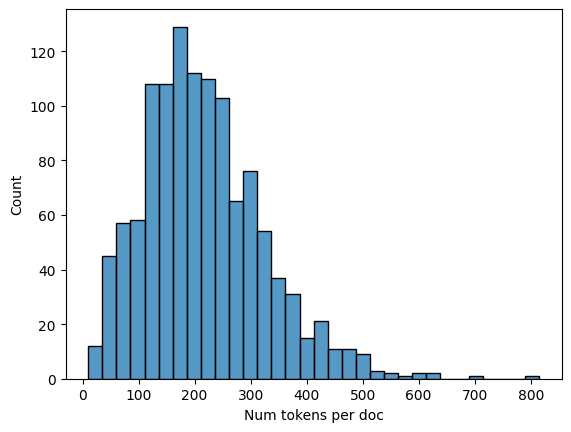

In [9]:
total_tokens = 0
for doc in corpus:
  total_tokens += len(doc)

print("Average number of tokens per review:", total_tokens / len(corpus))
num_tokens_per_doc = [len(doc) for doc in corpus]

sns.histplot(num_tokens_per_doc)
plt.xlabel("Num tokens per doc")
# La mayoria de los docs tienen alrededor de 200 token por doc
# Hay 120 docs con 190 tokens



#-----------------------------

tfidf_model = TfidfModel(dictionary=D)

# Create list of tuples with token id and ndocs
token_ndocs = [(D[id], ndocs) for id, ndocs in tfidf_model.dfs.items()]

# Create dataframe
df = pd.DataFrame(token_ndocs, columns=['token', 'ndocs'])
df_sorted = df.sort_values(by='ndocs', ascending=False)

# Remove the one that appear exactly one time
df_filtered = df[df['ndocs'] > 1].sort_values(by='ndocs', ascending=False)

most_common = df_filtered.nlargest(10, 'ndocs')
most_common.head()

- **Update the column clean_text with the new corpus and save it in a text file**

In [10]:
# Update it 
corpus_def = []
for sent in corpus:
  aux = [token for token in sent if token in D.token2id.keys()]
  corpus_def.append(aux)

dataset['Clean_text'] = [' '.join(x) for x in corpus_def]

# Save it
with open("clean_text.txt", 'w', encoding='utf-8') as fout:
  for el in dataset['Clean_text'].values.tolist():
    fout.write(''.join(el) + '\n')

###**• Step 2: Text vectorization. In this stage you will analyze the following vectorization schemes:**


#### **1. Classical BoW or TF-IDF representation.** 

- **Transform the documents using the dictionary**

In [11]:
def get_binary_label(testament): #New=1 Old=0
  return 1 if testament == "New" else 0

dataset['Binary_testament'] = dataset['Testament'].apply(get_binary_label)

Y = dataset['Binary_testament'].values

In [12]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset['Clean_text'],Y, test_size=0.3, random_state=42)

# Create a BoW representation of the text data
vectorizer_bow = CountVectorizer(vocabulary=D.token2id)
X_train_bow = vectorizer_bow.fit_transform(X_train)
X_test_bow = vectorizer_bow.transform(X_test)

# Create a TF-IDF representation of the text data
vectorizer_tfidf = TfidfVectorizer(vocabulary=D.token2id)
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

# Train an SVM classifier with the BoW representation
svm_bow = SVC()
svm_bow.fit(X_train_bow, y_train)
y_pred_bow_svm = svm_bow.predict(X_test_bow)
acc_bow_svm = accuracy_score(y_test, y_pred_bow_svm)

# Train an SVM classifier with the TF-IDF representation
svm_tfidf = SVC()
svm_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf_svm = svm_tfidf.predict(X_test_tfidf)
acc_tfidf_svm = accuracy_score(y_test, y_pred_tfidf_svm)

# Train a Naive Bayes classifier on the BoW representation
nb_bow = MultinomialNB()
nb_bow.fit(X_train_bow, y_train)
y_pred_bow_nb = nb_bow.predict(X_test_bow)

# Train a Naive Bayes classifier on the TF-IDF representation
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf_nb = nb_tfidf.predict(X_test_tfidf)

print("Results when analyzing how does it predict the testament:")
print("Accuracy (BoW) SVM:", acc_bow_svm)
print("Accuracy (TF-IDF) SVM:", acc_tfidf_svm)
print("Accuracy (BoW) NB:", accuracy_score(y_test, y_pred_bow_nb))
print("Accuracy (TF-IDF) NP:", accuracy_score(y_test, y_pred_tfidf_nb))


Results when analyzing how does it predict the testament:
Accuracy (BoW) SVM: 0.9662921348314607
Accuracy (TF-IDF) SVM: 0.9662921348314607
Accuracy (BoW) NB: 0.9971910112359551
Accuracy (TF-IDF) NP: 0.9129213483146067


In [13]:
Y = dataset['Book']
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset['Clean_text'],Y, test_size=0.3, random_state=42)

# Create a BoW representation of the text data
vectorizer_bow = CountVectorizer(vocabulary=D.token2id)
X_train_bow = vectorizer_bow.fit_transform(X_train)
X_test_bow = vectorizer_bow.transform(X_test)

# Create a TF-IDF representation of the text data
vectorizer_tfidf = TfidfVectorizer(vocabulary=D.token2id)
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

# Train an SVM classifier with the BoW representation
svm_bow = SVC()
svm_bow.fit(X_train_bow, y_train)
y_pred_bow_svm = svm_bow.predict(X_test_bow)
acc_bow_svm = accuracy_score(y_test, y_pred_bow_svm)

# Train an SVM classifier with the TF-IDF representation
svm_tfidf = SVC()
svm_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf_svm = svm_tfidf.predict(X_test_tfidf)
acc_tfidf_svm = accuracy_score(y_test, y_pred_tfidf_svm)

# Train a Naive Bayes classifier on the BoW representation
nb_bow = MultinomialNB()
nb_bow.fit(X_train_bow, y_train)
y_pred_bow_nb = nb_bow.predict(X_test_bow)

# Train a Naive Bayes classifier on the TF-IDF representation
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf_nb = nb_tfidf.predict(X_test_tfidf)

print("Results when analyzing how does it predict the book:")
print("Accuracy (BoW) SVM:", acc_bow_svm)
print("Accuracy (TF-IDF) SVM:", acc_tfidf_svm)
print("Accuracy (BoW) NB:", accuracy_score(y_test, y_pred_bow_nb))
print("Accuracy (TF-IDF) NP:", accuracy_score(y_test, y_pred_tfidf_nb))


Results when analyzing how does it predict the book:
Accuracy (BoW) SVM: 0.43820224719101125
Accuracy (TF-IDF) SVM: 0.42134831460674155
Accuracy (BoW) NB: 0.5674157303370787
Accuracy (TF-IDF) NP: 0.3651685393258427


- **Add a column to our dataset to each of the representations**

In [14]:
tfidf_matrix = vectorizer_tfidf.fit_transform(dataset["Clean_text"])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer_tfidf.vocabulary_.keys())
dataset["TF-IDF"] = tfidf_df.values.tolist()

bow_matrix = vectorizer_bow.fit_transform(dataset["Clean_text"])
bow_df = pd.DataFrame(bow_matrix.toarray(), columns=vectorizer_bow.vocabulary_.keys())
dataset["BoW"] = bow_df.values.tolist()

In [15]:
type(tfidf_matrix)

scipy.sparse._csr.csr_matrix

In [16]:
type(tfidf_df)

pandas.core.frame.DataFrame

In [17]:
dataset.head()

,Chapter,Book,Testament,Text,Clean_text,Entities,Entities_labs,Pos_tags,Binary_testament,TF-IDF,BoW
0,Capítulo 1,exodo,Old,Aflicción de los israelitas en Egipto 1:1 Est...,aflicción israelita egipto nombre israel entra...,Egipto Israel Egipto Jacob Rubén Simeón Leví J...,LOC LOC LOC PER PER PER MISC ORG PER PER LOC P...,PROPN NOUN PROPN NOUN NOUN PROPN VERB PROPN PR...,0,"[0.03611773378849263, 0.052319994336570294, 0....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,Capítulo 2,exodo,Old,Nacimiento de Moisés é2:1 Un varón de la fami...,nacimiento moisés varón familia leví tomar muj...,Nacimiento de Moisés é Un varón de la familia ...,MISC PER PER PER LOC PER PER PER PER PER MISC ...,NOUN PROPN CCONJ NOUN NOUN PROPN VERB NOUN NOU...,0,"[0.06341435350321382, 0.0, 0.0, 0.0, 0.0, 0.0,...","[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Capítulo 3,exodo,Old,Llamamiento de Moisésé3:1 Apacentando Moisés ...,llamamiento moisésé moisés oveja jetro_suegro ...,Llamamiento de Moisésé Apacentando Moisés Jetr...,ORG PER PER LOC LOC PER PER LOC LOC PER MISC M...,NOUN PROPN NUM PROPN NOUN PROPN NOUN NOUN PROP...,0,"[0.0, 0.09712090059455612, 0.0, 0.0, 0.0, 0.0,...","[0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
3,Capítulo 4,exodo,Old,é4:1 Entonces Moisés respondió diciendo: He ...,moisés responder creer oier_voz aparecer tener...,Moisés Jehová Jehová Una vara. El Echala Mois...,PER LOC LOC MISC PER PER PER PER MISC MISC MIS...,CCONJ PROPN VERB VERB VERB VERB NOUN VERB VERB...,0,"[0.03082591152021846, 0.04465428328372308, 0.0...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
4,Capítulo 5,exodo,Old,Moisés y Aarón ante Faraón é5:1 Después Moisé...,moisés_aarón faraón moisés_aarón entrar presen...,Moisés Aarón Faraón Moisés Aarón Faraón Jehová...,MISC LOC LOC MISC MISC PER MISC LOC PER LOC LO...,PROPN PROPN PROPN CCONJ PROPN PROPN VERB NOUN ...,0,"[0.0, 0.04149096468105849, 0.0, 0.0, 0.0, 0.0,...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."


####  **2. Word2vec/FastText based representation or Doc2Vec vectorization.** 


In [18]:
%%time
class IterableSentence_fromfile(object):
    def __init__(self, filename):
        self.__filename = filename
    
    def __iter__(self):
        for line in open(self.__filename):
            # assume there's one sentence per line, tokens separated by whitespace
            yield line.split()

sentences = IterableSentence_fromfile("clean_text.txt") # a memory-friendly iterator

# Train a Word2Vec 
model_w2v = Word2Vec(sentences, vector_size=200, window=5, sg=1, seed=42)
model_w2v.save("model_w2v_text.model")

word_vectors = model_w2v.wv
word_vectors.save("model_w2v_text.wordvectors")
#model_w2v = Word2Vec.load("model_w2v_text.model")

wv = KeyedVectors.load("model_w2v_text.wordvectors", mmap='r')

CPU times: user 12.9 s, sys: 142 ms, total: 13.1 s
Wall time: 7.02 s


In [19]:
# Load pre-trained Word2Vec model
wv = KeyedVectors.load("model_w2v_text.wordvectors", mmap='r')

# Read data and labels
with open('clean_text.txt', 'r') as f:
    data = [line.split(' ') for line in f.readlines()]

labels = dataset['Book'].values
#labels = dataset['Testament'].values

# Split data into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.3, random_state=42)

# Convert each sentence to its embedding representation using Word2Vec model
train_embeddings = []
for sentence in train_data:
    embeddings = []
    for word in sentence:
        if word in wv:
            embeddings.append(wv[word])
    if len(embeddings) > 0:
        train_embeddings.append(sum(embeddings) / len(embeddings))
    else:
        train_embeddings.append([0] * wv.vector_size)

test_embeddings = []
for sentence in test_data:
    embeddings = []
    for word in sentence:
        if word in wv:
            embeddings.append(wv[word])
    if len(embeddings) > 0:
        test_embeddings.append(sum(embeddings) / len(embeddings))
    else:
        test_embeddings.append([0] * wv.vector_size)

# Train SVM classifier using GridSearchCV for hyperparameter tuning
svm = SVC()
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', "poly"]}
grid_search = GridSearchCV(svm, param_grid, cv=5)
grid_search.fit(train_embeddings, train_labels)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Evaluate the performance of the classifier on the test set
svm = SVC(C=grid_search.best_params_['C'], kernel=grid_search.best_params_['kernel'])
svm.fit(train_embeddings, train_labels)
test_predictions = svm.predict(test_embeddings)
accuracy = accuracy_score(test_labels, test_predictions)
print("Accuracy on test set:", accuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best hyperparameters: {'C': 10, 'kernel': 'poly'}
Accuracy on test set: 0.5365168539325843


In [20]:
#Doc2Vec
tagged_docs = []
for i, doc in enumerate(corpus_def):
    tagged_doc = TaggedDocument(words=doc, tags=[i])
    tagged_docs.append(tagged_doc)


# train doc2vec model
model = Doc2Vec(tagged_docs, vector_size=100, window=5, min_count=1, epochs=20)

# get document vectors
doc_vectors = []
for i in range(len(corpus_def)):
    vector = model.docvecs[i]
    doc_vectors.append(vector)

labels = dataset['Book'].values

# Split data into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(doc_vectors, labels, test_size=0.3, random_state=42)

svm = SVC()
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
grid_search = GridSearchCV(svm, param_grid, cv=5)
grid_search.fit(train_data, train_labels)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Evaluate the performance of the classifier on the test set
svm = SVC(C=grid_search.best_params_['C'], kernel=grid_search.best_params_['kernel'])
svm.fit(train_data, train_labels)
test_predictions = svm.predict(test_data)
accuracy = accuracy_score(test_labels, test_predictions)
print("Accuracy on test set:", accuracy)

<ipython-input-20-88de64ad184a>:14: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  vector = model.docvecs[i]
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best hyperparameters: {'C': 10, 'kernel': 'rbf'}
Accuracy on test set: 0.5393258426966292


- **Add a column to our dataset to each of the vectorizations**

In [21]:
vectors = []
for sentence in dataset["Clean_text"]:
    embeddings = []
    for word in sentence:
        if word in wv:
            embeddings.append(wv[word])
    if len(embeddings) > 0:
        vectors.append(sum(embeddings) / len(embeddings))
    else:
        vectors.append([0] * wv.vector_size)

dataset["word2vec"] = vectors

vectors = [model.infer_vector(text.split()) for text in dataset['Clean_text']]
dataset["doc2vec"] = vectors

In [22]:
dataset.head()

,Chapter,Book,Testament,Text,Clean_text,Entities,Entities_labs,Pos_tags,Binary_testament,TF-IDF,BoW,word2vec,doc2vec
0,Capítulo 1,exodo,Old,Aflicción de los israelitas en Egipto 1:1 Est...,aflicción israelita egipto nombre israel entra...,Egipto Israel Egipto Jacob Rubén Simeón Leví J...,LOC LOC LOC PER PER PER MISC ORG PER PER LOC P...,PROPN NOUN PROPN NOUN NOUN PROPN VERB PROPN PR...,0,"[0.03611773378849263, 0.052319994336570294, 0....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.008967561, -0.010941909, -0.1033726, 0.0623...","[-0.9271143, -0.57347894, -0.32177782, 0.08499..."
1,Capítulo 2,exodo,Old,Nacimiento de Moisés é2:1 Un varón de la fami...,nacimiento moisés varón familia leví tomar muj...,Nacimiento de Moisés é Un varón de la familia ...,MISC PER PER PER LOC PER PER PER PER PER MISC ...,NOUN PROPN CCONJ NOUN NOUN PROPN VERB NOUN NOU...,0,"[0.06341435350321382, 0.0, 0.0, 0.0, 0.0, 0.0,...","[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.009525042, -0.0149832, -0.09827053, 0.06070...","[-1.8490782, -0.53745496, 0.19697489, 0.617187..."
2,Capítulo 3,exodo,Old,Llamamiento de Moisésé3:1 Apacentando Moisés ...,llamamiento moisésé moisés oveja jetro_suegro ...,Llamamiento de Moisésé Apacentando Moisés Jetr...,ORG PER PER LOC LOC PER PER LOC LOC PER MISC M...,NOUN PROPN NUM PROPN NOUN PROPN NOUN NOUN PROP...,0,"[0.0, 0.09712090059455612, 0.0, 0.0, 0.0, 0.0,...","[0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0.009035833, -0.011436829, -0.10274766, 0.062...","[-1.1196737, -0.63924783, 0.29954413, 0.072529..."
3,Capítulo 4,exodo,Old,é4:1 Entonces Moisés respondió diciendo: He ...,moisés responder creer oier_voz aparecer tener...,Moisés Jehová Jehová Una vara. El Echala Mois...,PER LOC LOC MISC PER PER PER PER MISC MISC MIS...,CCONJ PROPN VERB VERB VERB VERB NOUN VERB VERB...,0,"[0.03082591152021846, 0.04465428328372308, 0.0...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0.009024978, -0.0113581065, -0.1028471, 0.062...","[-0.72505957, -0.30992976, -0.02808709, 1.0109..."
4,Capítulo 5,exodo,Old,Moisés y Aarón ante Faraón é5:1 Después Moisé...,moisés_aarón faraón moisés_aarón entrar presen...,Moisés Aarón Faraón Moisés Aarón Faraón Jehová...,MISC LOC LOC MISC MISC PER MISC LOC PER LOC LO...,PROPN PROPN PROPN CCONJ PROPN PROPN VERB NOUN ...,0,"[0.0, 0.04149096468105849, 0.0, 0.0, 0.0, 0.0,...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0.009405379, -0.014115686, -0.09936573, 0.061...","[-0.75561833, -0.47295246, -0.23102781, 0.1600..."


####  **3. Extraction of themes and vector representation of the documents using the LDA algorithm.**

In [23]:
from gensim.models.ldamodel import LdaModel
import pyLDAvis.gensim as gensimvis
import pyLDAvis
from gensim.models.coherencemodel import CoherenceModel

In [24]:
# create the corpus BoW representation (LDA is based on BoW representation)
# list of tuples (token, frequency at each doc)
mycorpus_bow = [D.doc2bow(doc) for doc in corpus_def]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
# Use a coherence model to get the most optimal number of topics 
results_df = pd.DataFrame(columns=["n_topics", "coherence"])
for n_topics in range(5, 26):
  ldag = LdaModel(corpus=mycorpus_bow, id2word=D, num_topics=n_topics)
  coherencemodel = CoherenceModel(ldag, texts=corpus_def, dictionary=D, coherence='c_v')
  results = pd.DataFrame(data=[[n_topics, coherencemodel.get_coherence()]], columns=["n_topics", "coherence"])
  results_df = pd.concat([results_df, results])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<BarContainer object of 21 artists>

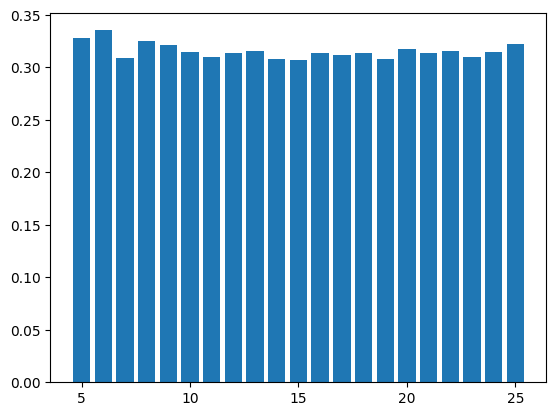

In [26]:
plt.bar(results_df["n_topics"], results_df["coherence"])

In [27]:
max = results_df.loc[results_df["coherence"] == results_df["coherence"].max()]
n = max["n_topics"][0]
coherence = max["coherence"][0]
print("The best number of topics is", n, "with the maximum coherence", coherence )

The best number of topics is 6 with the maximum coherence 0.335463101711619


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
# create the LDA object for best number of topics
ldag = LdaModel(corpus=mycorpus_bow, id2word=D, num_topics=n)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
# CHECK HOW MANY GRAPHS PER ROW AND COLUMN
for i in [5, 4, 3, 2]:
  if n%i==0:
    cols = i
    rows = int(n/i)
    break
  else:
    cols = n
    rows = 1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


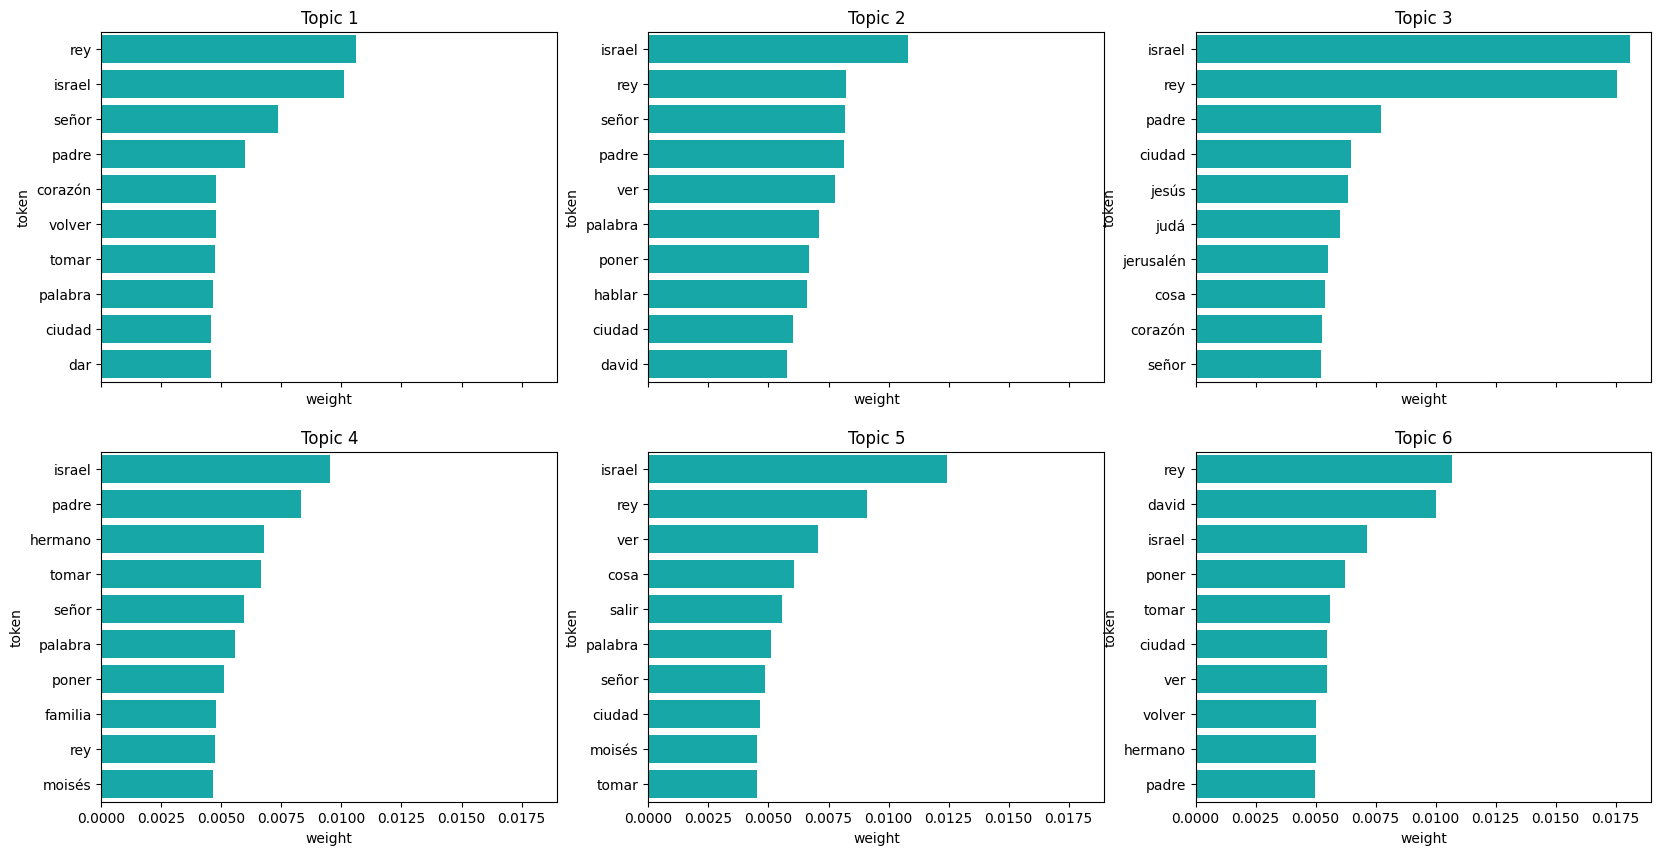

In [30]:
# Plot the topics
counter = 0
col = 0
row = 0

fig, axes = plt.subplots(rows, cols, figsize=(20, 10), sharex=True)

for i in range(n):
  topic_tokens = ldag.show_topic(i, topn=10)
  tokens = []
  weights = []

  for j in range(10):
    tokens.append(topic_tokens[j][0])
    weights.append(topic_tokens[j][1])

  df = pd.DataFrame({'token': tokens, 'weight': weights})
  
  if rows==1:
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[i])
    axes[i].set_title("Topic "+ str(i+1))
    
  
  else:
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[row][col])
    axes[row][col].set_title("Topic "+ str(i+1))
  
  # update parameters
  col += 1
  counter += 1

  # check if we must change of row
  if counter == cols:
    row += 1
    col = 0
    counter = 0
  



In [31]:
# Plot the topic representation using pyLDAvis
vis_data = gensimvis.prepare(ldag, mycorpus_bow, D)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pyLDAvis/_prepare.py:232: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  head(R).drop('saliency', 1)


- **Add a column with the predominant topic for each document**

In [32]:
def get_topic(lda_model, corpus, texts):
    # get the principal topic of each of the documents
    topics = []
    topics_dominant = []
    for i, text in enumerate(texts):
        tokens = text.split()
        bow = lda_model.id2word.doc2bow(tokens)
        
        # get the topic distribution
        doc_topics = lda_model.get_document_topics(bow)
        
        # # get the maximum probability topic
        max_prob = 0.0
        dominant_topic = -1
        for topic, prob in doc_topics:
            if prob > max_prob:
                max_prob = prob
                dominant_topic = topic
        
        topics_dominant.append(dominant_topic)
        topics.append(doc_topics)

    
    return topics, topics_dominant

dataset['topic'], dataset["dominant_topic"] = get_topic(ldag, mycorpus_bow, dataset['Clean_text'])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
dataset.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Chapter,Book,Testament,Text,Clean_text,Entities,Entities_labs,Pos_tags,Binary_testament,TF-IDF,BoW,word2vec,doc2vec,topic,dominant_topic
0,Capítulo 1,exodo,Old,Aflicción de los israelitas en Egipto 1:1 Est...,aflicción israelita egipto nombre israel entra...,Egipto Israel Egipto Jacob Rubén Simeón Leví J...,LOC LOC LOC PER PER PER MISC ORG PER PER LOC P...,PROPN NOUN PROPN NOUN NOUN PROPN VERB PROPN PR...,0,"[0.03611773378849263, 0.052319994336570294, 0....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.008967561, -0.010941909, -0.1033726, 0.0623...","[-0.9271143, -0.57347894, -0.32177782, 0.08499...","[(0, 0.034871917), (1, 0.80027), (3, 0.16087052)]",1
1,Capítulo 2,exodo,Old,Nacimiento de Moisés é2:1 Un varón de la fami...,nacimiento moisés varón familia leví tomar muj...,Nacimiento de Moisés é Un varón de la familia ...,MISC PER PER PER LOC PER PER PER PER PER MISC ...,NOUN PROPN CCONJ NOUN NOUN PROPN VERB NOUN NOU...,0,"[0.06341435350321382, 0.0, 0.0, 0.0, 0.0, 0.0,...","[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.009525042, -0.0149832, -0.09827053, 0.06070...","[-1.8490782, -0.53745496, 0.19697489, 0.617187...","[(0, 0.45695105), (1, 0.15630718), (3, 0.30949...",0
2,Capítulo 3,exodo,Old,Llamamiento de Moisésé3:1 Apacentando Moisés ...,llamamiento moisésé moisés oveja jetro_suegro ...,Llamamiento de Moisésé Apacentando Moisés Jetr...,ORG PER PER LOC LOC PER PER LOC LOC PER MISC M...,NOUN PROPN NUM PROPN NOUN PROPN NOUN NOUN PROP...,0,"[0.0, 0.09712090059455612, 0.0, 0.0, 0.0, 0.0,...","[0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0.009035833, -0.011436829, -0.10274766, 0.062...","[-1.1196737, -0.63924783, 0.29954413, 0.072529...","[(0, 0.9859744), (2, 0.010193204)]",0
3,Capítulo 4,exodo,Old,é4:1 Entonces Moisés respondió diciendo: He ...,moisés responder creer oier_voz aparecer tener...,Moisés Jehová Jehová Una vara. El Echala Mois...,PER LOC LOC MISC PER PER PER PER MISC MISC MIS...,CCONJ PROPN VERB VERB VERB VERB NOUN VERB VERB...,0,"[0.03082591152021846, 0.04465428328372308, 0.0...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0.009024978, -0.0113581065, -0.1028471, 0.062...","[-0.72505957, -0.30992976, -0.02808709, 1.0109...","[(0, 0.9666379), (3, 0.030319676)]",0
4,Capítulo 5,exodo,Old,Moisés y Aarón ante Faraón é5:1 Después Moisé...,moisés_aarón faraón moisés_aarón entrar presen...,Moisés Aarón Faraón Moisés Aarón Faraón Jehová...,MISC LOC LOC MISC MISC PER MISC LOC PER LOC LO...,PROPN PROPN PROPN CCONJ PROPN PROPN VERB NOUN ...,0,"[0.0, 0.04149096468105849, 0.0, 0.0, 0.0, 0.0,...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0.009405379, -0.014115686, -0.09936573, 0.061...","[-0.75561833, -0.47295246, -0.23102781, 0.1600...","[(0, 0.5813463), (5, 0.414031)]",0


We save the dataset with the new columns to use it for the Dashboard implementation:

In [34]:
drive.mount('/content/drive')

output_path = '/content/drive/My Drive/ColabNotebooks/MLapps/project/ModifiedDataset.pkl'

with open(output_path, 'wb') as f:
    pickle.dump(dataset, f)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **2. Task 2: Machine Learning model, Classification or Regression Task**

In [35]:
results_test = {}
results_val = {}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 1. Classification by testament

In [36]:
def split(col,label):

  #separate the feature set and label
  df_x = np.vstack(dataset[col])
  df_y = dataset[label].values

  # split the data into training, validation, and test sets
  x_train_val, x_test, y_train_val, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)
  x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.25, random_state=42)

  return x_train, y_train, x_val, y_val, x_test, y_test

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
def split_topic(col,label):

  #separate the feature set and label
  df_x = dataset[col]
  df_y = dataset[label].values

  # split the data into training, validation, and test sets
  x_train_val, x_test, y_train_val, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)
  x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.25, random_state=42)
  
  x_train = gensim.matutils.corpus2dense(x_train, num_terms=n).T
  x_val = gensim.matutils.corpus2dense(x_val, num_terms=n).T
  x_test = gensim.matutils.corpus2dense(x_test, num_terms=n).T

  return x_train, y_train, x_val, y_val, x_test, y_test

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
def svm_model(x_train,y_train,x_val,y_val,x_test,y_test):
  # Use GridSearchCV to find best hyperparameters
  svm = SVC()
  param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', "poly"]}
  grid_search = GridSearchCV(svm, param_grid, cv=5)
  grid_search.fit(x_train, y_train)


  # Train SVM classifier and evaluate its performance over validation and test sets
  svm = SVC(C=grid_search.best_params_['C'], kernel=grid_search.best_params_['kernel'])
  svm.fit(x_train, y_train)

  val_pred = svm.predict(x_val)
  val_accuracy = accuracy_score(y_val, val_pred)

  test_pred = svm.predict(x_test)
  test_accuracy = accuracy_score(y_test, test_pred)

  return grid_search.best_params_, val_accuracy, test_accuracy


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
def nbayes_model(x_train,y_train,x_val,y_val,x_test,y_test):
  
  nb = MultinomialNB()
  nb.fit(x_train, y_train)

  val_pred = nb.predict(x_val)
  val_accuracy = accuracy_score(y_val, val_pred)
  
  test_pred = nb.predict(x_test)
  test_accuracy = accuracy_score(y_test, test_pred)

  return val_accuracy, test_accuracy


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
def logReg_model(x_train,y_train,x_val,y_val,x_test,y_test):
  log = LogisticRegression()
  log.fit(x_train, y_train)

  val_pred = log.predict(x_val)
  test_pred = log.predict(x_test)

  val_accuracy = accuracy_score(y_val, val_pred)
  test_accuracy = accuracy_score(y_test, test_pred)
  
  return val_accuracy, test_accuracy

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Super Vector Classifier


In [41]:
# TF-IDF
x_train,y_train,x_val,y_val,x_test,y_test = split('TF-IDF','Binary_testament')
params_tfidf_testam_svc , val_acc_tfidf_testam_svc, test_acc_tfidf_testam_svc = svm_model(x_train,y_train,x_val,y_val,x_test,y_test)

print('Accuracy for the validation set:',val_acc_tfidf_testam_svc)
print('Accuracy for the test set:',test_acc_tfidf_testam_svc)

results_val["val_acc_tfidf_testam_svc"] = val_acc_tfidf_testam_svc
results_test["test_acc_tfidf_testam_svc"] = test_acc_tfidf_testam_svc

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Accuracy for the validation set: 0.9957805907172996
Accuracy for the test set: 1.0


In [42]:
# BoW
x_train,y_train,x_val,y_val,x_test,y_test = split('BoW','Binary_testament')
params_bow_testam_svc , val_acc_bow_testam_svc , test_acc_bow_testam_svc  = svm_model(x_train,y_train,x_val,y_val,x_test,y_test)

print('Accuracy for the validation set:',val_acc_bow_testam_svc )
print('Accuracy for the test set:',test_acc_bow_testam_svc )

results_val["val_acc_bow_testam_svc"] = val_acc_bow_testam_svc
results_test["test_acc_bow_testam_svc"] = test_acc_bow_testam_svc

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Accuracy for the validation set: 0.9915611814345991
Accuracy for the test set: 0.9704641350210971


In [43]:
# word2vec
x_train,y_train,x_val,y_val,x_test,y_test = split('word2vec','Binary_testament')
params_word2vec_testam_svc , val_acc_word2vec_testam_svc , test_acc_word2vec_testam_svc  = svm_model(x_train,y_train,x_val,y_val,x_test,y_test)

print('Accuracy for the validation set:',val_acc_word2vec_testam_svc)
print('Accuracy for the test set:',test_acc_word2vec_testam_svc )

results_val["val_acc_word2vec_testam_svc"] = val_acc_word2vec_testam_svc
results_test["test_acc_word2vec_testam_svc"] = test_acc_word2vec_testam_svc

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Accuracy for the validation set: 0.7679324894514767
Accuracy for the test set: 0.8016877637130801


In [44]:
# doc2vec
x_train,y_train,x_val,y_val,x_test,y_test = split('doc2vec','Binary_testament')
params_doc2vec_testam_svc, val_acc_doc2vec_testam_svc, test_acc_doc2vec_testam_svc = svm_model(x_train,y_train,x_val,y_val,x_test,y_test)

print('Accuracy for the validation set:',val_acc_doc2vec_testam_svc)
print('Accuracy for the test set:',test_acc_doc2vec_testam_svc)

results_val["val_acc_doc2vec_testam_svc"] = val_acc_doc2vec_testam_svc
results_test["test_acc_doc2vec_testam_svc"] = test_acc_doc2vec_testam_svc

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Accuracy for the validation set: 0.9915611814345991
Accuracy for the test set: 0.9957805907172996


In [45]:
# LDA
x_train,y_train,x_val,y_val,x_test,y_test = split_topic('topic','Binary_testament')
params_lda_testam_svc, val_acc_lda_testam_svc, test_acc_lda_testam_svc = svm_model(x_train,y_train,x_val,y_val,x_test,y_test)

print('Accuracy for the validation set:',val_acc_lda_testam_svc)
print('Accuracy for the test set:',test_acc_lda_testam_svc)

results_val["val_acc_lda_testam_svc"] = val_acc_lda_testam_svc
results_test["test_acc_lda_testam_svc"] = test_acc_lda_testam_svc

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Accuracy for the validation set: 0.729957805907173
Accuracy for the test set: 0.8059071729957806


#### Naive Bayes

In [46]:
# TF-IDF
x_train,y_train,x_val,y_val,x_test,y_test = split('TF-IDF','Binary_testament')
val_acc_tfidf_testam_nb, test_acc_tfidf_testam_nb = nbayes_model(x_train,y_train,x_val,y_val,x_test,y_test)

print('Accuracy for the validation set:',val_acc_tfidf_testam_nb)
print('Accuracy for the test set:',test_acc_tfidf_testam_nb)

results_val["val_acc_tfidf_testam_nb"] = val_acc_tfidf_testam_nb
results_test["test_acc_tfidf_testam_nb"] = test_acc_tfidf_testam_nb

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Accuracy for the validation set: 0.9029535864978903
Accuracy for the test set: 0.890295358649789


In [47]:
# BoW
x_train,y_train,x_val,y_val,x_test,y_test = split('BoW','Binary_testament')
val_acc_bow_testam_nb, test_acc_bow_testam_nb = nbayes_model(x_train,y_train,x_val,y_val,x_test,y_test)

print('Accuracy for the validation set:',val_acc_bow_testam_nb)
print('Accuracy for the test set:',test_acc_bow_testam_nb)

results_val["val_acc_bow_testam_nb"] = val_acc_bow_testam_nb
results_test["test_acc_bow_testam_nb"] = test_acc_bow_testam_nb

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Accuracy for the validation set: 0.9831223628691983
Accuracy for the test set: 0.9957805907172996


In [48]:
# LDA
x_train,y_train,x_val,y_val,x_test,y_test = split_topic('topic','Binary_testament')
val_acc_lda_testam_nb, test_acc_lda_testam_nb = nbayes_model(x_train,y_train,x_val,y_val,x_test,y_test)

print('Accuracy for the validation set:',val_acc_lda_testam_nb)
print('Accuracy for the test set:',test_acc_lda_testam_nb)


results_val["val_acc_lda_testam_nb"] = val_acc_lda_testam_nb
results_test["test_acc_lda_testam_nb"] = test_acc_lda_testam_nb

Accuracy for the validation set: 0.7679324894514767
Accuracy for the test set: 0.8016877637130801


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Logistic Regression


In [49]:
# TF-IDF
x_train,y_train,x_val,y_val,x_test,y_test = split('TF-IDF','Binary_testament')
val_acc_tfidf_testam_lr, test_acc_tfidf_testam_lr = logReg_model(x_train,y_train,x_val,y_val,x_test,y_test)

print('Accuracy for the validation set:',val_acc_tfidf_testam_lr)
print('Accuracy for the test set:',test_acc_tfidf_testam_lr)

results_val["val_acc_tfidf_testam_lr"] = val_acc_tfidf_testam_lr
results_test["test_acc_tfidf_testam_lr"] = test_acc_tfidf_testam_lr

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Accuracy for the validation set: 0.9240506329113924
Accuracy for the test set: 0.919831223628692


In [50]:
# BoW
x_train,y_train,x_val,y_val,x_test,y_test = split('BoW','Binary_testament')
val_acc_bow_testam_lr , test_acc_bow_testam_lr  = logReg_model(x_train,y_train,x_val,y_val,x_test,y_test)

print('Accuracy for the validation set:',val_acc_bow_testam_lr)
print('Accuracy for the test set:',test_acc_bow_testam_lr)

results_val["val_acc_bow_testam_lr"] = val_acc_bow_testam_lr
results_test["test_acc_bow_testam_lr"] = test_acc_bow_testam_lr

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Accuracy for the validation set: 0.9915611814345991
Accuracy for the test set: 0.9620253164556962


In [51]:
# word2vec
x_train,y_train,x_val,y_val,x_test,y_test = split('word2vec','Binary_testament')
val_acc_word2vec_testam_lr , test_acc_word2vec_testam_lr  = logReg_model(x_train,y_train,x_val,y_val,x_test,y_test)

print('Accuracy for the validation set:',val_acc_word2vec_testam_lr)
print('Accuracy for the test set:',test_acc_word2vec_testam_lr)

results_val["val_acc_word2vec_testam_lr"] = val_acc_word2vec_testam_lr
results_test["test_acc_word2vec_testam_lr"] = test_acc_word2vec_testam_lr

Accuracy for the validation set: 0.7679324894514767
Accuracy for the test set: 0.8016877637130801


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
# doc2vec
x_train,y_train,x_val,y_val,x_test,y_test = split('doc2vec','Binary_testament')
val_acc_doc2vec_testam_lr, test_acc_doc2vec_testam_lr = logReg_model(x_train,y_train,x_val,y_val,x_test,y_test)

print('Accuracy for the validation set:',val_acc_doc2vec_testam_lr)
print('Accuracy for the test set:',test_acc_doc2vec_testam_lr)

results_val["val_acc_doc2vec_testam_lr"] = val_acc_doc2vec_testam_lr
results_test["test_acc_doc2vec_testam_lr"] = test_acc_doc2vec_testam_lr

Accuracy for the validation set: 0.9873417721518988
Accuracy for the test set: 0.9957805907172996


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [53]:
# LDA
x_train,y_train,x_val,y_val,x_test,y_test = split_topic('topic','Binary_testament')
val_acc_lda_testam_lr, test_acc_lda_testam_lr = logReg_model(x_train,y_train,x_val,y_val,x_test,y_test)

print('Accuracy for the validation set:',val_acc_lda_testam_lr)
print('Accuracy for the test set:',test_acc_lda_testam_lr)

results_val["val_acc_lda_testam_lr"] = val_acc_lda_testam_lr
results_test["test_acc_lda_testam_lr"] = test_acc_lda_testam_lr

Accuracy for the validation set: 0.759493670886076
Accuracy for the test set: 0.8227848101265823


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 2. Classification by book

#### Super Vector Classifier

In [54]:
# TF-IDF
x_train,y_train,x_val,y_val,x_test,y_test = split('TF-IDF','Book')
params_tfidf_book_svc, val_acc_tfidf_book_svc, test_acc_tfidf_book_svc = svm_model(x_train,y_train,x_val,y_val,x_test,y_test)

print('Accuracy for the validation set:',val_acc_tfidf_book_svc)
print('Accuracy for the test set:',test_acc_tfidf_book_svc)

results_val["val_acc_tfidf_book_svc"] = val_acc_tfidf_book_svc
results_test["test_acc_tfidf_book_svc"] = test_acc_tfidf_book_svc

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Accuracy for the validation set: 0.5443037974683544
Accuracy for the test set: 0.5864978902953587


In [55]:
# BoW
x_train,y_train,x_val,y_val,x_test,y_test = split('BoW','Book')
params_bow_book_svc, val_acc_bow_book_svc, test_acc_bow_book_svc = svm_model(x_train,y_train,x_val,y_val,x_test,y_test)

print('Accuracy for the validation set:',val_acc_bow_book_svc)
print('Accuracy for the test set:',test_acc_bow_book_svc)

results_val["val_acc_bow_book_svc"] = val_acc_bow_book_svc
results_test["test_acc_bow_book_svc"] = test_acc_bow_book_svc

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Accuracy for the validation set: 0.5527426160337553
Accuracy for the test set: 0.5485232067510548


In [56]:
# word2vec
x_train,y_train,x_val,y_val,x_test,y_test = split('word2vec','Book')
params_word2vec_book_svc, val_acc_word2vec_book_svc, test_acc_word2vec_book_svc = svm_model(x_train,y_train,x_val,y_val,x_test,y_test)

print('Accuracy for the validation set:',val_acc_word2vec_book_svc)
print('Accuracy for the test set:',test_acc_word2vec_book_svc)

results_val["val_acc_word2vec_book_svc"] = val_acc_word2vec_book_svc
results_test["test_acc_word2vec_book_svc"] = test_acc_word2vec_book_svc

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Accuracy for the validation set: 0.0379746835443038
Accuracy for the test set: 0.0759493670886076


In [57]:
# doc2vec
x_train,y_train,x_val,y_val,x_test,y_test = split('doc2vec','Book')
params_doc2vec_book_svc, val_acc_doc2vec_book_svc, test_acc_doc2vec_book_svc = svm_model(x_train,y_train,x_val,y_val,x_test,y_test)

print('Accuracy for the validation set:',val_acc_doc2vec_book_svc)
print('Accuracy for the test set:',test_acc_doc2vec_book_svc)

results_val["val_acc_doc2vec_book_svc"] = val_acc_doc2vec_book_svc
results_test["test_acc_doc2vec_book_svc"] = test_acc_doc2vec_book_svc

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Accuracy for the validation set: 0.5189873417721519
Accuracy for the test set: 0.5443037974683544


In [58]:
# lda
x_train,y_train,x_val,y_val,x_test,y_test = split_topic('topic','Book')
params_lda_book_svc, val_acc_lda_book_svc, test_acc_lda_book_svc = svm_model(x_train,y_train,x_val,y_val,x_test,y_test)

print('Accuracy for the validation set:',val_acc_lda_book_svc)
print('Accuracy for the test set:',test_acc_lda_book_svc)

results_val["val_acc_lda_book_svc"] = val_acc_lda_book_svc
results_test["test_acc_lda_book_svc"] = test_acc_lda_book_svc

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Accuracy for the validation set: 0.08016877637130802
Accuracy for the test set: 0.10126582278481013


#### Naive Bayes 

In [59]:
# TF-IDF
x_train,y_train,x_val,y_val,x_test,y_test = split('TF-IDF','Book')
val_acc_tfidf_book_nb, test_acc_tfidf_book_nb = nbayes_model(x_train,y_train,x_val,y_val,x_test,y_test)

print('Accuracy for the validation set:',val_acc_tfidf_book_nb)
print('Accuracy for the test set:',test_acc_tfidf_book_nb)

results_val["val_acc_tfidf_book_nb"] = val_acc_tfidf_book_nb
results_test["test_acc_tfidf_book_nb"] = test_acc_tfidf_book_nb

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Accuracy for the validation set: 0.27848101265822783
Accuracy for the test set: 0.3333333333333333


In [60]:
# BoW
x_train,y_train,x_val,y_val,x_test,y_test = split('BoW','Book')
val_acc_bow_book_nb, test_acc_bow_book_nb = nbayes_model(x_train,y_train,x_val,y_val,x_test,y_test)

print('Accuracy for the validation set:',val_acc_bow_book_nb)
print('Accuracy for the test set:',test_acc_bow_book_nb)

results_val["val_acc_bow_book_nb"] = val_acc_bow_book_nb
results_test["test_acc_bow_book_nb"] = test_acc_bow_book_nb

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Accuracy for the validation set: 0.4219409282700422
Accuracy for the test set: 0.5147679324894515


In [61]:
# lda
x_train,y_train,x_val,y_val,x_test,y_test = split_topic('topic','Book')
val_acc_lda_book_nb, test_acc_lda_book_nb = nbayes_model(x_train,y_train,x_val,y_val,x_test,y_test)

print('Accuracy for the validation set:',val_acc_lda_book_nb)
print('Accuracy for the test set:',test_acc_lda_book_nb)

results_val["val_acc_lda_book_nb"] = val_acc_lda_book_nb
results_test["test_acc_lda_book_nb"] = test_acc_lda_book_nb

Accuracy for the validation set: 0.08438818565400844
Accuracy for the test set: 0.10126582278481013


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Results

In [63]:
test_results_df = pd.DataFrame({"Model":list(results_test.keys()), "Accuracy": list(results_test.values())})
val_results_df = pd.DataFrame({"Model":list(results_val.keys()), "Accuracy": list(results_val.values())})

# store it
test_results_df.to_csv('/content/drive/My Drive/ColabNotebooks/MLapps/project/datos_dash/test_results.csv', index=False)
val_results_df.to_csv('/content/drive/My Drive/ColabNotebooks/MLapps/project/datos_dash/val_results.csv', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


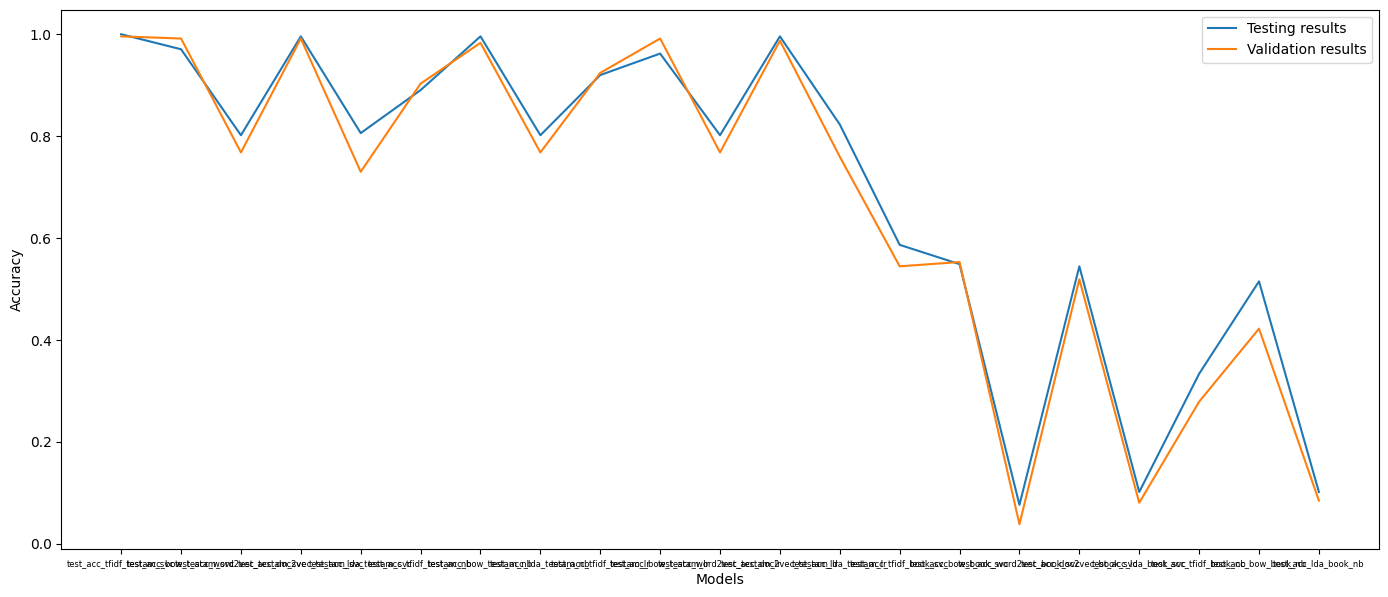

In [64]:
# Plot the results
plt.figure(figsize=(17, 7))
plt.plot(results_test.keys(), results_test.values(), label='Testing results')
plt.plot(results_test.keys(), results_val.values(), label='Validation results')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(fontsize=6)
plt.legend()
plt.show()


#### Datasets creation fro the Dash


##### SVC

In [65]:
# SVC testament + book prediction,  TF-IDF
# TESTAMENT
df_x = np.vstack(dataset["TF-IDF"])
df_y = dataset["Testament"].values
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)

svm = SVC()
svm.fit(x_train, y_train)

test_pred = svm.predict(x_test)
test_accuracy = accuracy_score(y_test, test_pred)

tfidf_svc = pd.DataFrame({"Testament": y_test, "Testament_Prediction": test_pred})

# BOOK
df_x = np.vstack(dataset["TF-IDF"])
df_y = dataset["Book"].values
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)

svm = SVC()
svm.fit(x_train, y_train)

test_pred = svm.predict(x_test)
test_accuracy = accuracy_score(y_test, test_pred)

tfidf_svc["Book"] = y_test
tfidf_svc["Book_Prediction"] = test_pred


tfidf_svc.to_csv('/content/drive/My Drive/ColabNotebooks/MLapps/project/datos_dash/tfidf_svc_results.csv', index=False)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [66]:
# SVC testament + book prediction,  BoW
# TESTAMENT
df_x = np.vstack(dataset["BoW"])
df_y = dataset["Testament"].values
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)

svm = SVC()
svm.fit(x_train, y_train)

test_pred = svm.predict(x_test)
test_accuracy = accuracy_score(y_test, test_pred)

bow_svc = pd.DataFrame({"Testament": y_test, "Testament_Prediction": test_pred})

# BOOK
df_x = np.vstack(dataset["BoW"])
df_y = dataset["Book"].values
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)

svm = SVC()
svm.fit(x_train, y_train)

test_pred = svm.predict(x_test)
test_accuracy = accuracy_score(y_test, test_pred)

bow_svc["Book"] = y_test
bow_svc["Book_Prediction"] = test_pred


bow_svc.to_csv('/content/drive/My Drive/ColabNotebooks/MLapps/project/datos_dash/bow_svc_results.csv', index=False)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [67]:
# SVC testament + book prediction,  word2Vec
# TESTAMENT
df_x = np.vstack(dataset["word2vec"])
df_y = dataset["Testament"].values
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)

svm = SVC()
svm.fit(x_train, y_train)

test_pred = svm.predict(x_test)
test_accuracy = accuracy_score(y_test, test_pred)

word2vec_svc = pd.DataFrame({"Testament": y_test, "Testament_Prediction": test_pred})

# BOOK
df_x = np.vstack(dataset["word2vec"])
df_y = dataset["Book"].values
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)

svm = SVC()
svm.fit(x_train, y_train)

test_pred = svm.predict(x_test)
test_accuracy = accuracy_score(y_test, test_pred)

word2vec_svc["Book"] = y_test
word2vec_svc["Book_Prediction"] = test_pred


word2vec_svc.to_csv('/content/drive/My Drive/ColabNotebooks/MLapps/project/datos_dash/word2vec_svc_results.csv', index=False)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [68]:
# SVC testament + book prediction,  doc2vec
# TESTAMENT
df_x = np.vstack(dataset["doc2vec"])
df_y = dataset["Testament"].values
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)

svm = SVC()
svm.fit(x_train, y_train)

test_pred = svm.predict(x_test)
test_accuracy = accuracy_score(y_test, test_pred)

doc2vec_svc = pd.DataFrame({"Testament": y_test, "Testament_Prediction": test_pred})

# BOOK
df_x = np.vstack(dataset["doc2vec"])
df_y = dataset["Book"].values
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)

svm = SVC()
svm.fit(x_train, y_train)

test_pred = svm.predict(x_test)
test_accuracy = accuracy_score(y_test, test_pred)

doc2vec_svc["Book"] = y_test
doc2vec_svc["Book_Prediction"] = test_pred


doc2vec_svc.to_csv('/content/drive/My Drive/ColabNotebooks/MLapps/project/datos_dash/doc2vec_svc_results.csv', index=False)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [69]:
# SVC testament + book prediction,  topic
# TESTAMENT
df_x = (dataset["topic"])
df_y = dataset["Testament"].values
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)
x_train = gensim.matutils.corpus2dense(x_train, num_terms=n).T
x_test = gensim.matutils.corpus2dense(x_test, num_terms=n).T

svm = SVC()
svm.fit(x_train, y_train)

test_pred = svm.predict(x_test)
test_accuracy = accuracy_score(y_test, test_pred)

topic_svc = pd.DataFrame({"Testament": y_test, "Testament_Prediction": test_pred})

# BOOK
df_x = (dataset["topic"])
df_y = dataset["Book"].values
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)
x_train = gensim.matutils.corpus2dense(x_train, num_terms=n).T
x_test = gensim.matutils.corpus2dense(x_test, num_terms=n).T

svm = SVC()
svm.fit(x_train, y_train)

test_pred = svm.predict(x_test)
test_accuracy = accuracy_score(y_test, test_pred)

topic_svc["Book"] = y_test
topic_svc["Book_Prediction"] = test_pred


topic_svc.to_csv('/content/drive/My Drive/ColabNotebooks/MLapps/project/datos_dash/topic_svc_results.csv', index=False)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##### Naive Bayes

In [70]:
# NB testament + book prediction,  TF-IDF
# TESTAMENT
df_x = np.vstack(dataset["TF-IDF"])
df_y = dataset["Testament"].values
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)

nb = MultinomialNB()
nb.fit(x_train, y_train)

test_pred = nb.predict(x_test)
test_accuracy = accuracy_score(y_test, test_pred)

tfidf_nb = pd.DataFrame({"Testament": y_test, "Testament_Prediction": test_pred})

# BOOK
df_x = np.vstack(dataset["TF-IDF"])
df_y = dataset["Book"].values
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)

nb = MultinomialNB()
nb.fit(x_train, y_train)

test_pred = nb.predict(x_test)
test_accuracy = accuracy_score(y_test, test_pred)

tfidf_nb["Book"] = y_test
tfidf_nb["Book_Prediction"] = test_pred


tfidf_nb.to_csv('/content/drive/My Drive/ColabNotebooks/MLapps/project/datos_dash/tfidf_nb_results.csv', index=False)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [71]:
# NB testament + book prediction,  BoW
# TESTAMENT
df_x = np.vstack(dataset["BoW"])
df_y = dataset["Testament"].values
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)

nb = MultinomialNB()
nb.fit(x_train, y_train)

test_pred = nb.predict(x_test)
test_accuracy = accuracy_score(y_test, test_pred)

bow_nb = pd.DataFrame({"Testament": y_test, "Testament_Prediction": test_pred})

# BOOK
df_x = np.vstack(dataset["BoW"])
df_y = dataset["Book"].values
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)

nb = MultinomialNB()
nb.fit(x_train, y_train)

test_pred = nb.predict(x_test)
test_accuracy = accuracy_score(y_test, test_pred)

bow_nb["Book"] = y_test
bow_nb["Book_Prediction"] = test_pred


bow_nb.to_csv('/content/drive/My Drive/ColabNotebooks/MLapps/project/datos_dash/bow_nb_results.csv', index=False)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [72]:
# NB testament + book prediction,  topic
# TESTAMENT
df_x = (dataset["topic"])
df_y = dataset["Testament"].values
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)
x_train = gensim.matutils.corpus2dense(x_train, num_terms=n).T
x_test = gensim.matutils.corpus2dense(x_test, num_terms=n).T

nb = MultinomialNB()
nb.fit(x_train, y_train)

test_pred = nb.predict(x_test)
test_accuracy = accuracy_score(y_test, test_pred)

topic_nb = pd.DataFrame({"Testament": y_test, "Testament_Prediction": test_pred})

# BOOK
df_x = (dataset["topic"])
df_y = dataset["Book"].values
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)
x_train = gensim.matutils.corpus2dense(x_train, num_terms=n).T
x_test = gensim.matutils.corpus2dense(x_test, num_terms=n).T

nb = MultinomialNB()
nb.fit(x_train, y_train)

test_pred = nb.predict(x_test)
test_accuracy = accuracy_score(y_test, test_pred)

topic_nb["Book"] = y_test
topic_nb["Book_Prediction"] = test_pred


topic_nb.to_csv('/content/drive/My Drive/ColabNotebooks/MLapps/project/datos_dash/topic_nb_results.csv', index=False)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
